In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random
import time

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

In [3]:
# specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# reproducibility
RANDOM_STATE = 1
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## Data Loading

In [5]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/CNN")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import dict_act, NN, train_NN, count_parameters


saved in: c:\Users\xinch\Desktop\RBI\models\CNN_complex_fe


## Data Extraction

In [8]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [9]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 242)
(411257,)
(102815, 242)
(102815,)


### Normalization

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X)
X_train_scaled = X_scaled[idx_train]
X_test_scaled = X_scaled[idx_test]
X_TEST_scaled = scaler.transform(X_TEST)

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

# add channel dimension for CNN
X_train_scaled = np.expand_dims(X_train_scaled,1)
X_test_scaled = np.expand_dims(X_test_scaled,1)
X_TEST_scaled = np.expand_dims(X_TEST_scaled,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 1, 242)
(411257, 1)
(102815, 1, 242)
(102815, 1)
(20135, 1, 242)
(20135, 1)


## CNN

In [16]:
class CNN_baseline(nn.Module):
    def __init__(
        self, 
        base_channels,
        activation_fn, 
        use_dropout=False, 
        use_bn=False
    ):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels =1, out_channels=base_channels, kernel_size=22, stride=11, padding=0)
        self.conv2 = nn.Conv1d(in_channels =base_channels, out_channels=2*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels =2*base_channels, out_channels=4*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv1d(in_channels =4*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)

        # self.pool = nn.MaxPool1d(2, 2)

        self.fc = nn.Linear(in_features=128, out_features=1) # TODO

        self.conv_block1 = self.generate_conv_block(self.conv1, activation_fn, use_dropout, use_bn)
        self.conv_block2 = self.generate_conv_block(self.conv2, activation_fn, use_dropout, use_bn)
        self.conv_block3 = self.generate_conv_block(self.conv3, activation_fn, use_dropout, use_bn)
        self.conv_block4 = self.generate_conv_block(self.conv4, activation_fn, use_dropout, use_bn)

    def generate_conv_block(self, conv, activation_fn, use_dropout, use_bn):
        """conv-bn-activation-dropout"""
        layers = []
        layers.append(conv) 
        if use_bn:
            layers.append(nn.BatchNorm1d(conv.out_channels))
        layers.append(activation_fn)
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

### Init

In [17]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 32,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline.pth"
model = CNN_baseline(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


8489

In [18]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [19]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [20]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [21]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
    save=False,
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:.2f} seconds")


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 746.78, test loss : 568.26, TEST loss : 562.94, lr: 0.0010
epoch : 10, train loss : 6.79, test loss : 6.76, TEST loss : 10.36, lr: 0.0010
epoch : 20, train loss : 3.98, test loss : 4.04, TEST loss : 7.21, lr: 0.0010
epoch : 30, train loss : 2.96, test loss : 2.68, TEST loss : 5.16, lr: 0.0010
epoch : 40, train loss : 2.46, test loss : 3.78, TEST loss : 5.03, lr: 0.0010
epoch : 50, train loss : 2.17, test loss : 1.84, TEST loss : 3.96, lr: 0.0010
epoch : 60, train loss : 1.98, test loss : 2.38, TEST loss : 4.51, lr: 0.0010
epoch : 70, train loss : 1.85, test loss : 1.85, TEST loss : 3.93, lr: 0.0010
epoch : 80, train loss : 1.75, test loss : 1.46, TEST loss : 3.54, lr: 0.0010
epoch : 90, train loss : 1.65, test loss : 1.49, TEST loss : 3.46, lr: 0.0010
epoch : 100, train loss : 1.58, test loss : 1.39, TEST loss : 3.26, lr: 0.0010
epoch : 110, train loss : 1.52, test loss : 1.46, TEST loss : 3.37, lr: 0.0010
epoch : 120, train loss : 1.45, test loss : 1.20, TEST l

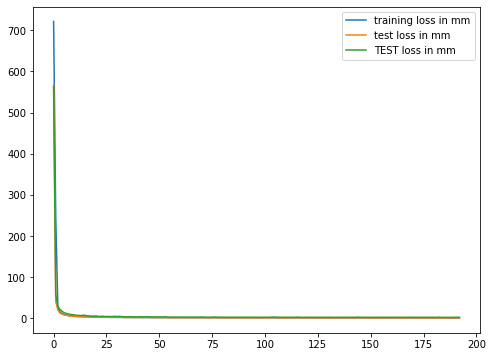

In [23]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [18]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
    (1): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
)

In [19]:
# evaluation on  training, test and TEST set on 3090

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 0.74 mm
test RMSE: 0.73 mm
TEST RMSE: 1.74 mm


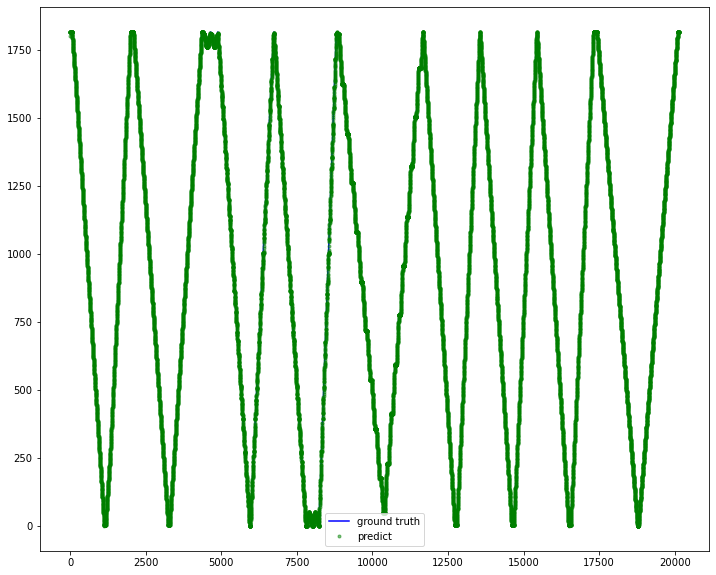

In [26]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


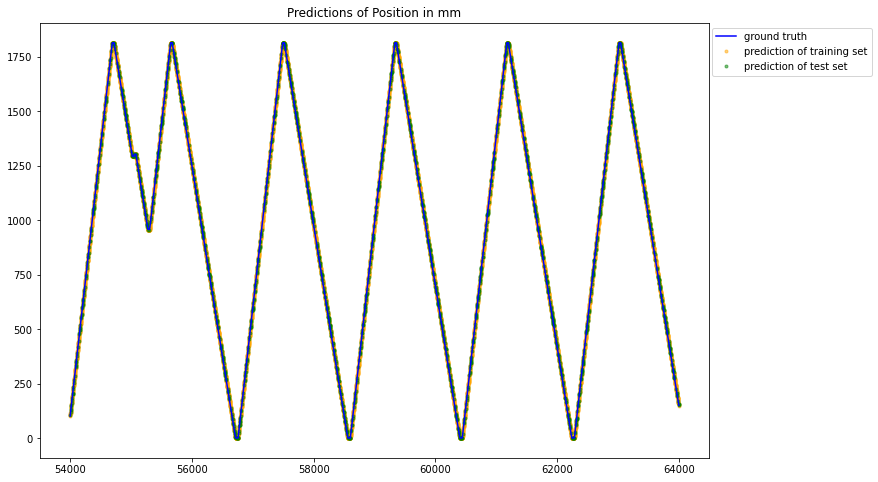

In [27]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN

### Init

In [28]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline.pth"
model = CNN_baseline(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


8489

In [29]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [30]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [31]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [32]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 839.78, test loss : 641.54, TEST loss : 635.73, lr: 0.0010
epoch : 10, train loss : 8.94, test loss : 8.42, TEST loss : 14.73, lr: 0.0010
epoch : 20, train loss : 4.54, test loss : 4.28, TEST loss : 8.63, lr: 0.0010
epoch : 30, train loss : 3.07, test loss : 2.82, TEST loss : 6.21, lr: 0.0010
epoch : 40, train loss : 2.39, test loss : 2.38, TEST loss : 4.92, lr: 0.0010
epoch : 50, train loss : 1.98, test loss : 1.94, TEST loss : 4.56, lr: 0.0010
epoch : 60, train loss : 1.72, test loss : 1.66, TEST loss : 3.98, lr: 0.0010
epoch : 70, train loss : 1.54, test loss : 1.59, TEST loss : 3.31, lr: 0.0010
epoch : 80, train loss : 1.41, test loss : 1.59, TEST loss : 3.15, lr: 0.0010
epoch : 90, train loss : 1.31, test loss : 1.37, TEST loss : 2.88, lr: 0.0010
epoch : 100, train loss : 1.23, test loss : 1.12, TEST loss : 2.50, lr: 0.0010
epoch : 110, train loss : 1.16, test loss : 1.19, TEST loss : 2.50, lr: 0.0010
epoch : 120, train loss : 1.10, test loss : 1.20, TEST l

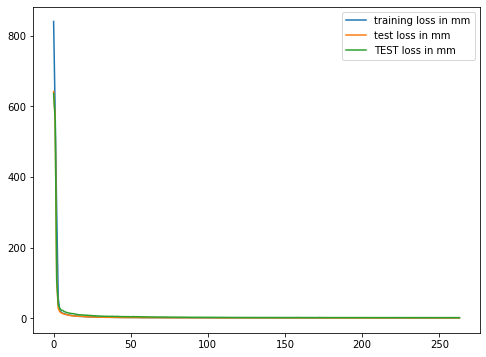

In [33]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [34]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
    (1): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
)

In [35]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 0.73 mm
test RMSE: 0.75 mm
TEST RMSE: 1.74 mm


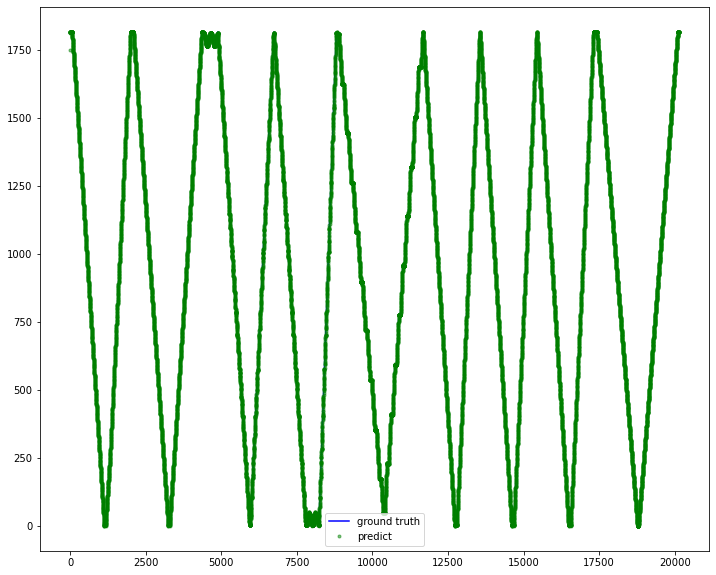

In [36]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


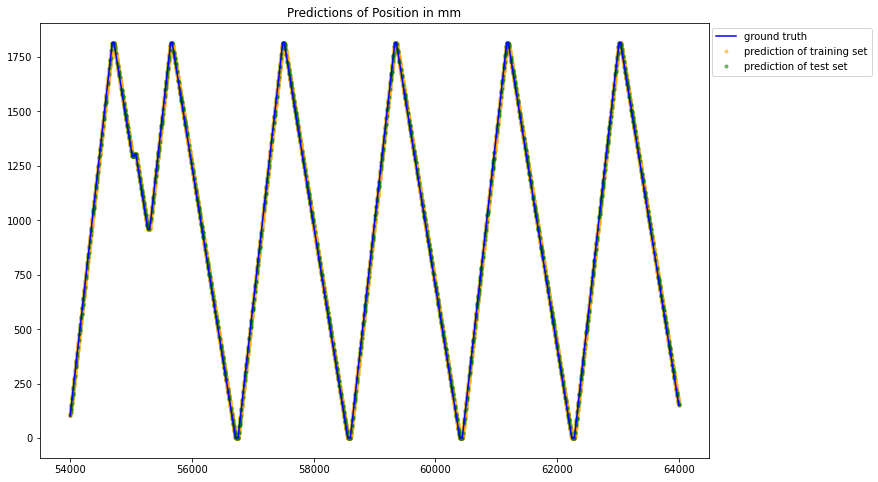

In [37]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN

### Init

In [11]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline.pth"
model = CNN_baseline(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


8489

In [74]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [19]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [20]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [21]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 941.26, test loss : 813.99, TEST loss : 808.57, lr: 0.0010
epoch : 10, train loss : 17.63, test loss : 16.42, TEST loss : 25.78, lr: 0.0010
epoch : 20, train loss : 7.99, test loss : 7.80, TEST loss : 12.61, lr: 0.0010
epoch : 30, train loss : 5.44, test loss : 5.30, TEST loss : 8.93, lr: 0.0010
epoch : 40, train loss : 4.17, test loss : 4.28, TEST loss : 7.30, lr: 0.0010
epoch : 50, train loss : 3.42, test loss : 3.19, TEST loss : 5.75, lr: 0.0010
epoch : 60, train loss : 2.94, test loss : 2.77, TEST loss : 4.93, lr: 0.0010
epoch : 70, train loss : 2.65, test loss : 2.80, TEST loss : 4.53, lr: 0.0010
epoch : 80, train loss : 2.40, test loss : 2.23, TEST loss : 4.15, lr: 0.0010
epoch : 90, train loss : 2.23, test loss : 2.27, TEST loss : 3.92, lr: 0.0010
epoch : 100, train loss : 2.10, test loss : 2.14, TEST loss : 4.08, lr: 0.0010
epoch : 110, train loss : 1.98, test loss : 1.99, TEST loss : 3.80, lr: 0.0010
epoch : 120, train loss : 1.89, test loss : 1.74, TES

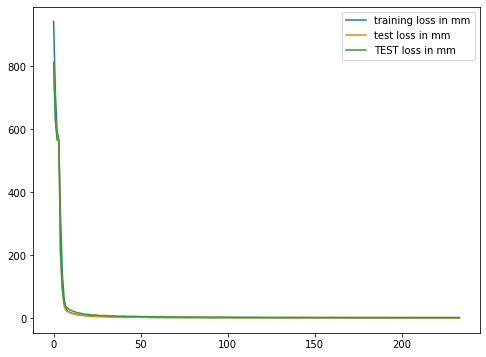

In [22]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [23]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
    (1): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
)

In [24]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 1.29 mm
test RMSE: 1.30 mm
TEST RMSE: 2.82 mm


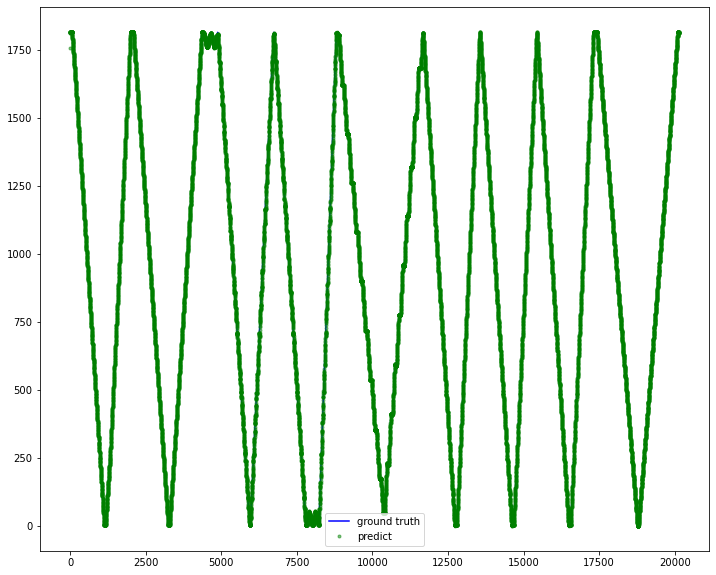

In [25]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


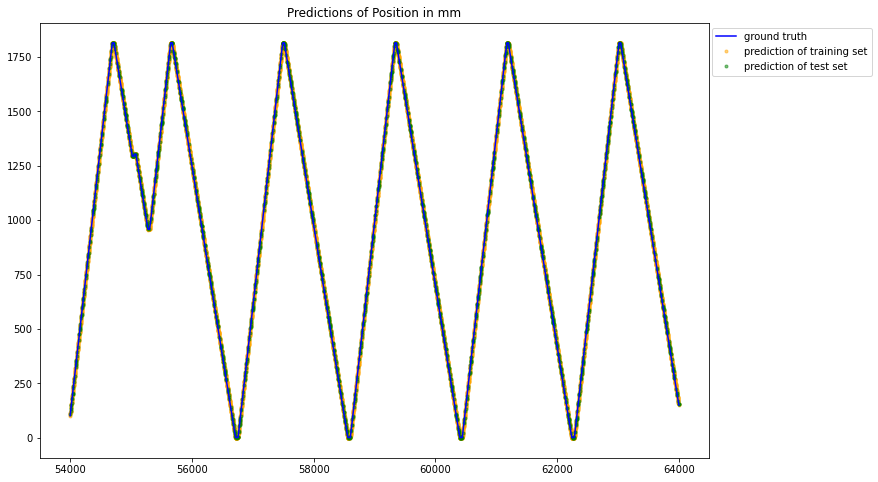

In [26]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN with bn

### Init

In [27]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": True,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline_bn.pth"
model = CNN_baseline(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


8729

In [28]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [29]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [30]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [31]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 781.19, test loss : 498.92, TEST loss : 494.64, lr: 0.0010
epoch : 10, train loss : 4.72, test loss : 3.35, TEST loss : 4.14, lr: 0.0010
epoch : 20, train loss : 3.68, test loss : 2.66, TEST loss : 3.15, lr: 0.0010
epoch : 30, train loss : 3.26, test loss : 2.41, TEST loss : 3.12, lr: 0.0010
epoch : 40, train loss : 2.99, test loss : 3.03, TEST loss : 3.28, lr: 0.0010
epoch : 50, train loss : 2.89, test loss : 2.05, TEST loss : 2.76, lr: 0.0010
Early stopping triggered
The minimal test loss is 1.86 from epoch 39


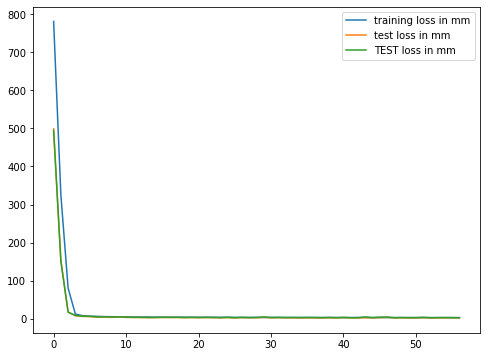

In [32]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [33]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(64, eps=1

In [34]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 1.84 mm
test RMSE: 1.86 mm
TEST RMSE: 2.67 mm


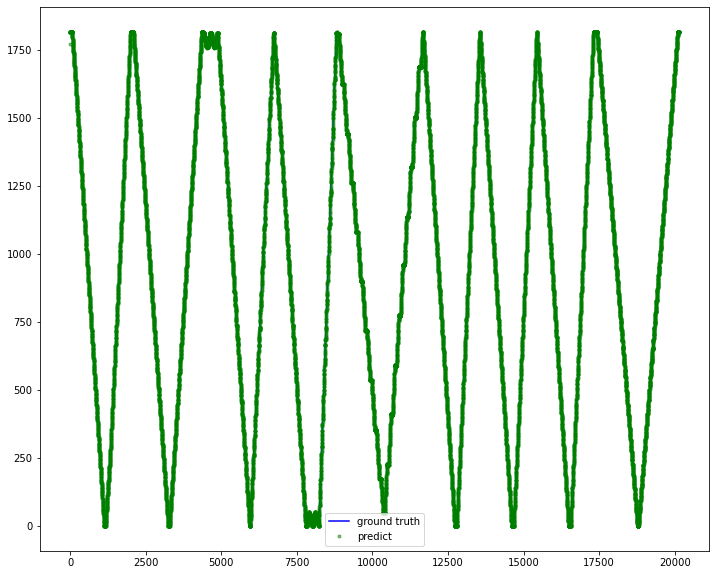

In [35]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


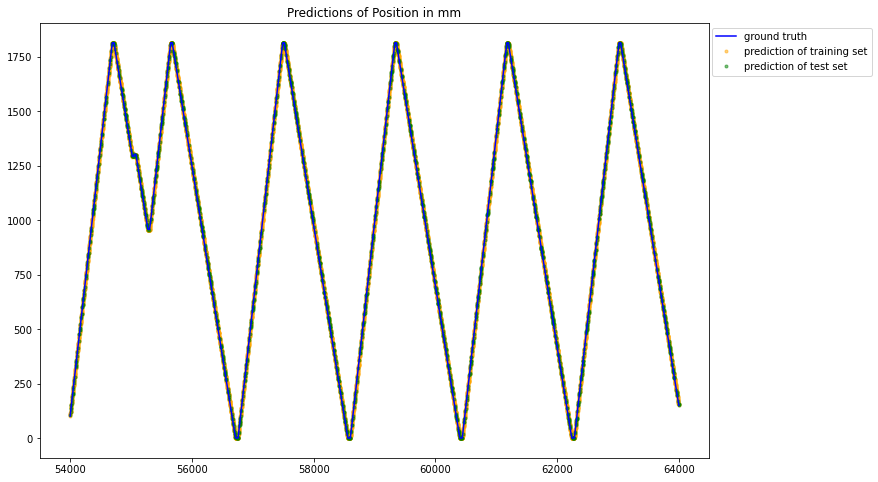

In [36]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN with bn

### Init

In [75]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": True,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline_bn.pth"
model = CNN_baseline(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


8729

In [76]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [29]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [30]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [31]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 912.66, test loss : 749.17, TEST loss : 744.47, lr: 0.0010
epoch : 10, train loss : 5.69, test loss : 4.11, TEST loss : 5.83, lr: 0.0010
epoch : 20, train loss : 4.03, test loss : 2.93, TEST loss : 4.24, lr: 0.0010
epoch : 30, train loss : 3.46, test loss : 2.67, TEST loss : 3.87, lr: 0.0010
epoch : 40, train loss : 3.13, test loss : 2.49, TEST loss : 3.68, lr: 0.0010
epoch : 50, train loss : 2.93, test loss : 2.33, TEST loss : 3.56, lr: 0.0010
epoch : 60, train loss : 2.77, test loss : 2.44, TEST loss : 3.47, lr: 0.0010
epoch : 70, train loss : 2.64, test loss : 1.83, TEST loss : 3.08, lr: 0.0010
epoch : 80, train loss : 2.54, test loss : 1.85, TEST loss : 2.92, lr: 0.0010
epoch : 90, train loss : 2.47, test loss : 1.90, TEST loss : 2.99, lr: 0.0010
Early stopping triggered
The minimal test loss is 1.59 from epoch 79


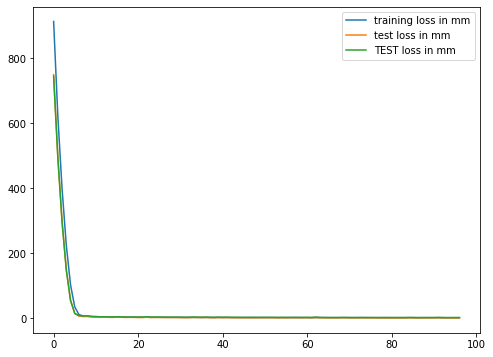

In [32]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [33]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(64, eps=1

In [34]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 1.57 mm
test RMSE: 1.59 mm
TEST RMSE: 2.94 mm


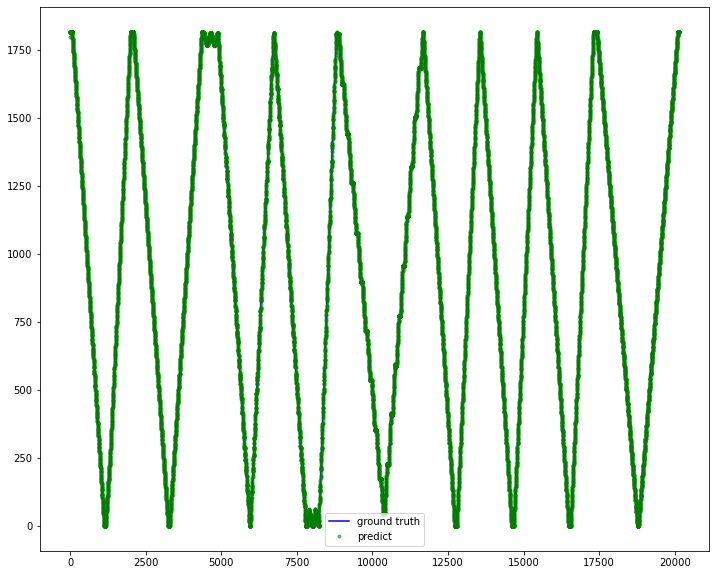

In [35]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


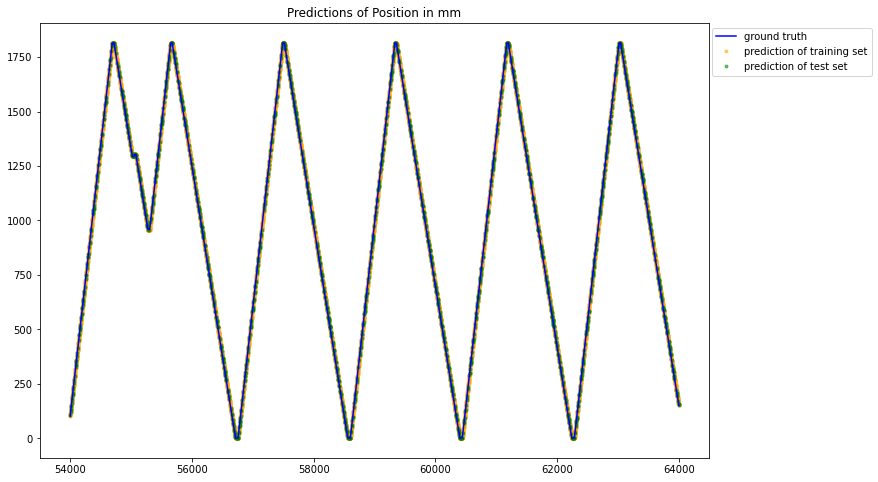

In [36]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN with dropout

### Init

In [82]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": True,
    "use_bn": True,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline_dr.pth"
model = CNN_baseline(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


8729

In [83]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [84]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [85]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [86]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 916.30, test loss : 744.70, TEST loss : 740.05, lr: 0.0010
epoch : 10, train loss : 156.95, test loss : 65.49, TEST loss : 70.61, lr: 0.0010
epoch : 20, train loss : 150.18, test loss : 52.11, TEST loss : 63.39, lr: 0.0010
epoch : 30, train loss : 147.44, test loss : 54.72, TEST loss : 64.98, lr: 0.0010
epoch : 40, train loss : 146.00, test loss : 46.99, TEST loss : 63.72, lr: 0.0010
epoch : 50, train loss : 145.20, test loss : 49.04, TEST loss : 62.40, lr: 0.0010
Early stopping triggered
The minimal test loss is 46.99 from epoch 40


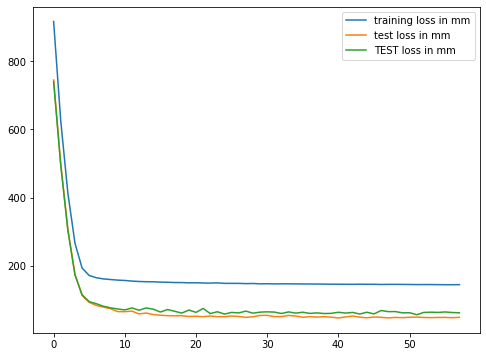

In [87]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [88]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(11,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Dropout(p=0.5, inplace=False)
 

In [89]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 47.07 mm
test RMSE: 47.00 mm
TEST RMSE: 63.72 mm


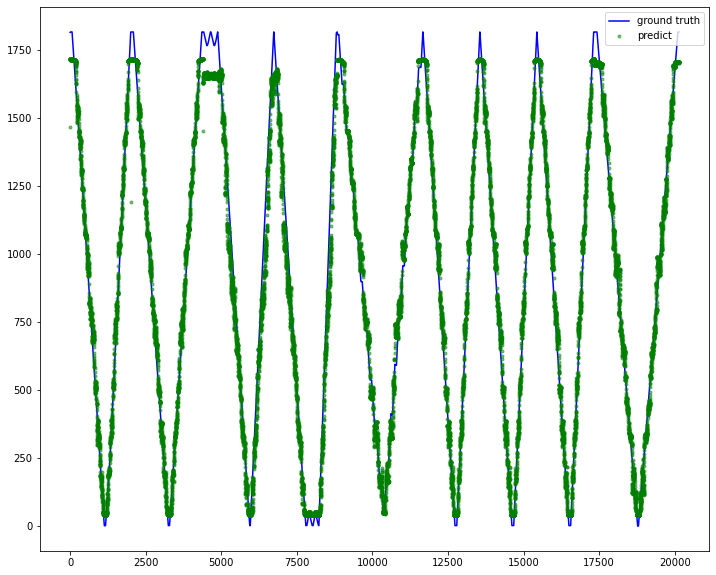

In [90]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


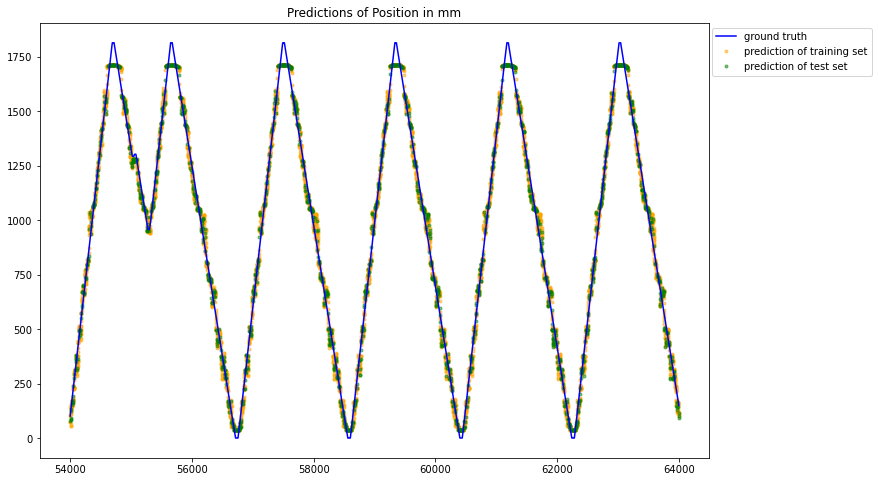

In [91]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN wider

In [15]:
class CNN(nn.Module):
    def __init__(
        self, 
        base_channels,
        activation_fn, 
        use_dropout=False, 
        use_bn=False
    ):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels =1, out_channels=base_channels, kernel_size=22, stride=11, padding=0)
        self.conv2 = nn.Conv1d(in_channels =base_channels, out_channels=2*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels =2*base_channels, out_channels=4*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv1d(in_channels =4*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)

        # self.pool = nn.MaxPool1d(2, 2)

        self.fc = nn.Linear(in_features=256, out_features=1) # TODO

        self.conv_block1 = self.generate_conv_block(self.conv1, activation_fn, use_dropout, use_bn)
        self.conv_block2 = self.generate_conv_block(self.conv2, activation_fn, use_dropout, use_bn)
        self.conv_block3 = self.generate_conv_block(self.conv3, activation_fn, use_dropout, use_bn)
        self.conv_block4 = self.generate_conv_block(self.conv4, activation_fn, use_dropout, use_bn)

    def generate_conv_block(self, conv, activation_fn, use_dropout, use_bn):
        """conv-bn-activation-dropout"""
        layers = []
        layers.append(conv) 
        if use_bn:
            layers.append(nn.BatchNorm1d(conv.out_channels))
        layers.append(activation_fn)
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

### Init

In [16]:
# configuration
_config = {
    "base_channels": 16,
    "activation": "sigmoid",
    "batch_size": 32,
    "epochs": 500,
    "decay_after": 100,
    "patience": 8,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_wider.pth"
model = CNN(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


33105

In [17]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [18]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [19]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [20]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:.2f} seconds")


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 646.55, test loss : 198.53, TEST loss : 204.27, lr: 0.0010
epoch : 10, train loss : 2.40, test loss : 2.52, TEST loss : 3.78, lr: 0.0010
epoch : 20, train loss : 1.53, test loss : 1.43, TEST loss : 2.35, lr: 0.0010
epoch : 30, train loss : 1.23, test loss : 0.94, TEST loss : 1.85, lr: 0.0010
epoch : 40, train loss : 1.06, test loss : 1.02, TEST loss : 1.68, lr: 0.0010
epoch : 50, train loss : 0.97, test loss : 0.84, TEST loss : 1.49, lr: 0.0010
epoch : 60, train loss : 0.92, test loss : 0.85, TEST loss : 1.44, lr: 0.0010
epoch : 70, train loss : 0.87, test loss : 0.82, TEST loss : 1.40, lr: 0.0010
Early stopping triggered
The minimal test loss is 0.73 from epoch 63
Training time: 2041.29 seconds


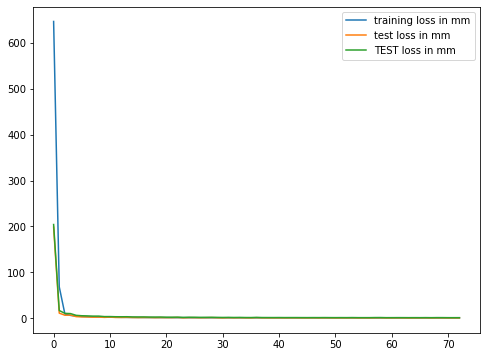

In [21]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [22]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN(
  (conv1): Conv1d(1, 16, kernel_size=(22,), stride=(11,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(22,), stride=(11,))
    (1): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
)

In [23]:
# evaluation on  training, test and TEST set on 3090

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 0.72 mm
test RMSE: 0.73 mm
TEST RMSE: 1.42 mm


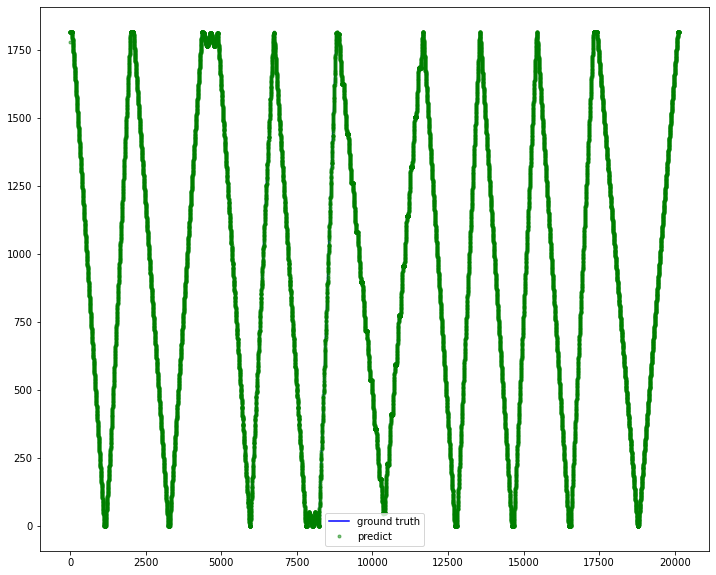

In [24]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


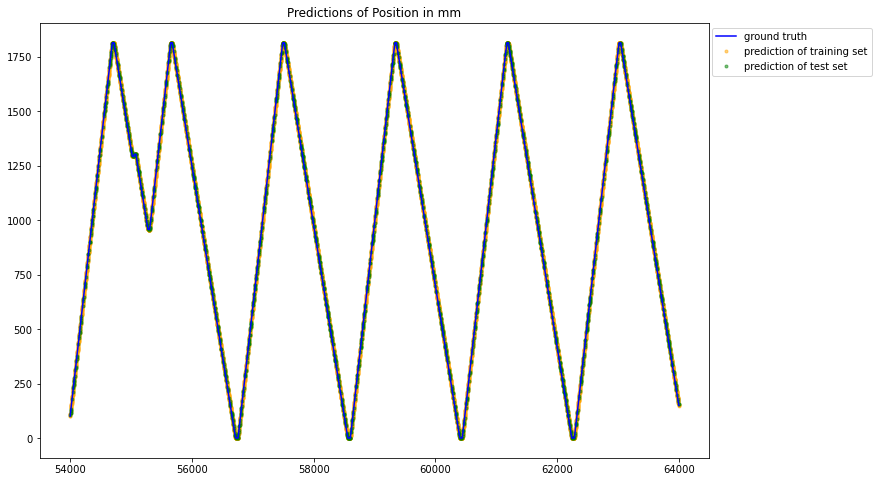

In [25]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## CNN deeper

In [43]:
class CNN(nn.Module):
    def __init__(
        self, 
        base_channels,
        activation_fn, 
        use_dropout=False, 
        use_bn=False
    ):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels =1, out_channels=base_channels, kernel_size=22, stride=7, padding=0)
        self.conv2 = nn.Conv1d(in_channels =base_channels, out_channels=2*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels =2*base_channels, out_channels=4*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv1d(in_channels =4*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv1d(in_channels =8*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv1d(in_channels =8*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)


        # self.pool = nn.MaxPool1d(2, 2)

        self.fc = nn.Linear(in_features=64, out_features=1) # TODO

        self.conv_block1 = self.generate_conv_block(self.conv1, activation_fn, use_dropout, use_bn)
        self.conv_block2 = self.generate_conv_block(self.conv2, activation_fn, use_dropout, use_bn)
        self.conv_block3 = self.generate_conv_block(self.conv3, activation_fn, use_dropout, use_bn)
        self.conv_block4 = self.generate_conv_block(self.conv4, activation_fn, use_dropout, use_bn)
        self.conv_block5 = self.generate_conv_block(self.conv5, activation_fn, use_dropout, use_bn)
        self.conv_block6 = self.generate_conv_block(self.conv6, activation_fn, use_dropout, use_bn)

    def generate_conv_block(self, conv, activation_fn, use_dropout, use_bn):
        """conv-bn-activation-dropout"""
        layers = []
        layers.append(conv) 
        if use_bn:
            layers.append(nn.BatchNorm1d(conv.out_channels))
        layers.append(activation_fn)
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

### Init

In [44]:
# configuration
_config = {
    "base_channels": 8,
    "activation": "sigmoid",
    "batch_size": 32,
    "epochs": 500,
    "decay_after": 100,
    "patience": 8,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_deeper.pth"
model = CNN(
    base_channels=config.base_channels,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


33129

In [45]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [46]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [47]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [48]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:.2f} seconds")


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 880.84, test loss : 699.08, TEST loss : 695.58, lr: 0.0010
epoch : 10, train loss : 567.82, test loss : 568.03, TEST loss : 562.66, lr: 0.0010
epoch : 20, train loss : 567.82, test loss : 568.04, TEST loss : 562.66, lr: 0.0010
Early stopping triggered
The minimal test loss is 568.03 from epoch 12
Training time: 814.67 seconds


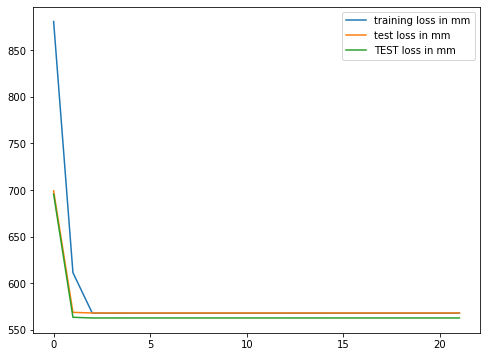

In [49]:
plot_3_losses(train_losses, test_losses, TEST_losses)

### Evaluation

In [50]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN(
  (conv1): Conv1d(1, 8, kernel_size=(22,), stride=(7,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(22,), stride=(7,))
    (1): Sigmoid()
  )
  (conv_block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
    (1): Sigmoid()
  )
  (conv_block4): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
  (conv_block5): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
  (conv_block6): Sequential(
    (0): Conv1d(64, 64, kernel_size

In [51]:
# evaluation on  training, test and TEST set on 3090

with torch.no_grad():
    y_ = model(torch.Tensor(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 567.82 mm
test RMSE: 568.03 mm
TEST RMSE: 562.66 mm


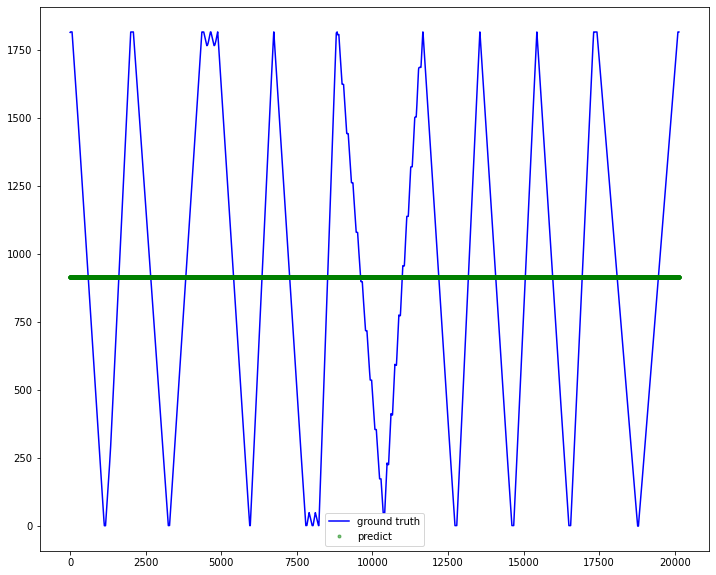

In [52]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


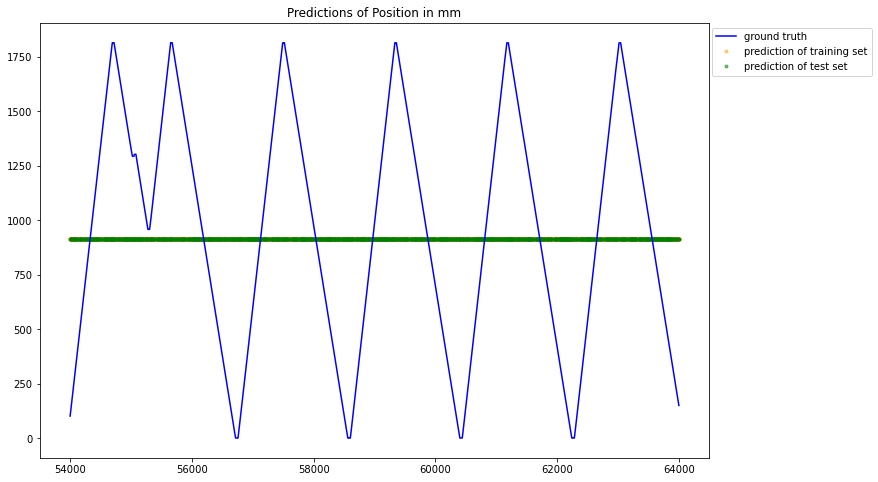

In [53]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
